### Hugging Face Transformers 라이브러리 CLIP 모델로 이미지와 문자의 유사도 확인하기

-- 입력한 이미지 --


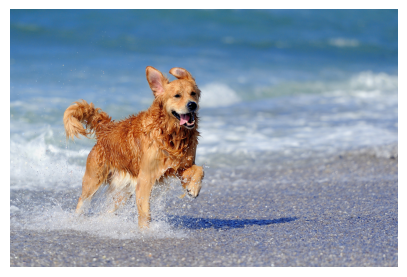

유사도: tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward0>)


In [2]:
## 이미지와 문자의 유사도 확인하기
# !pip install transformers
# !pip install torch torchvision
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import torch

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # 경고창 안 뜨게하기 (병렬처리 비활성화)

# 모델 및 프로세서 불러오기
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# 대조할 이미지와 텍스트 불러오기
image = Image.open("/Users/dgriii0606/Downloads/example image and caption/example0.jpg")
texts = ["a photo of a banana", "a photo of a dog"]

# 입력한 데이터 변환
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)

# 모델 실행
outputs = model(**inputs)

# 특징 벡터 추출
image_ft = outputs.image_embeds
text_ft = outputs.text_embeds

image_ft.shape  # [1, 512]
text_ft.shape   # [2, 512]

# 유사도 계산하기
result = ( image_ft @ text_ft.T ).softmax(dim=-1)  # 특징 벡터의 점곱에 소프트맥스 함수를 취해 내적 결과 값을 확률로 출력
                                                   # dim=-1은 텐서의 마지막 차원에서 소프트맥스를 수행하겠다.

# 입력한 이미지 보이기
print("-- 입력한 이미지 --")
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

# 유사도 출력
print(f"유사도: {result}")  # [0.4780, 0.5220]  # "a photo of a dog" 문장이 0.5220 확률로 나옴

### 캐글 Flickr-8k 데이터셋으로 이미지 캡셔닝 실습하기

In [4]:
## 캐글 flickr-8k 데이터셋으로 이미지 캡셔닝 실습하기
import os
import pandas as pd
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
import random

# CLIP 모델 및 프로세서 불러오기
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# 오픈 데이터셋 경로 지정
dataset_path = "/Users/dgriii0606/data/flickr-8k"
image_folder = os.path.join(dataset_path, "Images")
caption_file = os.path.join(dataset_path, "captions.txt")

# 캡션 txt 파일 불러오기
captions_df = pd.read_csv(caption_file, delimiter=",")
captions_df.columns = ["image", "caption"]  # 열 이름 설정
captions_df = captions_df.dropna()  # 결측치 제거

# 이미지 및 캡션 확인
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


-- 데이터셋에서 랜덤으로 뽑은 이미지 --


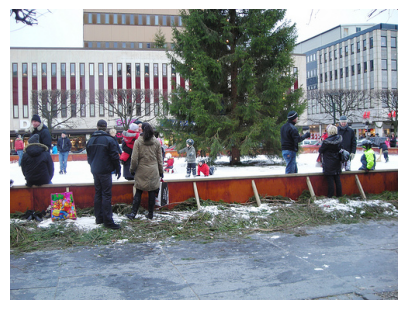

해당 이미지의 캡션: Kids play in the snow while parents watch


In [10]:
# 오픈 데이터셋에서 랜덤 이미지 하나 뽑고 해당 이미지의 캡션 선택하기
random_index = random.randint(0, len(captions_df) - 1)
random_row = captions_df.iloc[random_index]
image_path = os.path.join(image_folder, random_row["image"])
caption = random_row["caption"]

# 이미지 랜덤으로 뽑고 해당 캡션 출력
image = Image.open(image_path)

print("-- 데이터셋에서 랜덤으로 뽑은 이미지 --")
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

print(f"해당 이미지의 캡션: {caption}")

In [12]:
# 해당 이미지 경로로 이미지를 불러와서 유사도가 큰 캡션을 불러오는 함수
def generate_caption(image_path, captions_list):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    
    # 입력받은 캡션 후보 리스트들을 모두 임베딩하기
    text_inputs = processor(text=captions_list, return_tensors="pt", padding=True)
    text_features = model.get_text_features(**text_inputs)
    
    # 임베딩한 캡션 텍스트와 이미지와의 유사도 계산
    similarities = torch.nn.functional.cosine_similarity(outputs, text_features)
    best_index = similarities.argmax().item()  # 가장 높은 유사도를 가진 인덱스 계산

    # 결과 출력  # 유사도 값과 인덱스를 담고 리스트 순번에 맞게 유사도 출력
    print("입력한 Caption List와 코사인 유사도")
    for i, sim in enumerate(similarities):
        print(f"{captions_list[i]} ==> 유사도: {sim.item():.4f}")

    # 유사도 중 가장 값이 큰 유사도 반환
    return captions_list[best_index]

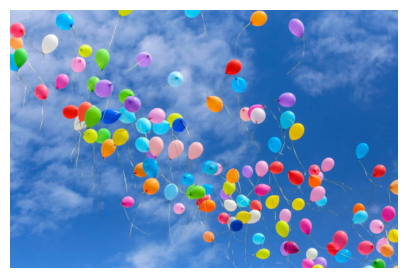

입력한 Caption List와 코사인 유사도
a watery dog with running fur splashing on the beach. ==> 유사도: 0.1211
An orange streetlight is shining on the road in the dark night. ==> 유사도: 0.1610
A long cactus stands tall in the desolate green-brown desert. ==> 유사도: 0.1347
A slice of pizza topped with green basil leaves is lifted with a pizza knife and cheese is served. ==> 유사도: 0.1293
The whole world is white and covered with snow. ==> 유사도: 0.1705
Two children play ball in a green grass field, and a mother and father run toward the children with a smile. ==> 유사도: 0.1747
Colorful balloons fly into the sky in the blue sky. ==> 유사도: 0.3289
a white coffee cup on a small wooden table ==> 유사도: 0.0985
A group of small yellow fish is swimming in the blue sea. ==> 유사도: 0.2117
People are sitting on the subway to work without empty seats. ==> 유사도: 0.1667

유사도가 가장 높은 캡션: Colorful balloons fly into the sky in the blue sky.

====



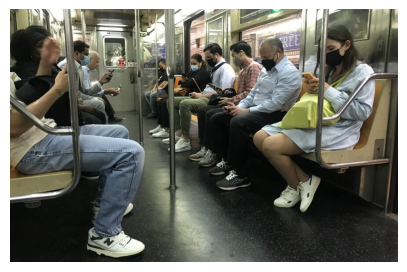

입력한 Caption List와 코사인 유사도
a watery dog with running fur splashing on the beach. ==> 유사도: 0.0821
An orange streetlight is shining on the road in the dark night. ==> 유사도: 0.1855
A long cactus stands tall in the desolate green-brown desert. ==> 유사도: 0.1275
A slice of pizza topped with green basil leaves is lifted with a pizza knife and cheese is served. ==> 유사도: 0.1602
The whole world is white and covered with snow. ==> 유사도: 0.1691
Two children play ball in a green grass field, and a mother and father run toward the children with a smile. ==> 유사도: 0.1098
Colorful balloons fly into the sky in the blue sky. ==> 유사도: 0.1325
a white coffee cup on a small wooden table ==> 유사도: 0.1711
A group of small yellow fish is swimming in the blue sea. ==> 유사도: 0.1836
People are sitting on the subway to work without empty seats. ==> 유사도: 0.3451

유사도가 가장 높은 캡션: People are sitting on the subway to work without empty seats.


In [14]:
# 이미지 캡셔닝 실행 (이미지 -> 텍스트 매칭)
example_image1 = "/Users/dgriii0606/Downloads/example image and caption/example6.jpg"
example_image2 = "/Users/dgriii0606/Downloads/example image and caption/example9.jpg"

example_caption_list = [
                        "a watery dog with running fur splashing on the beach.",
                        "An orange streetlight is shining on the road in the dark night.",
                        "A long cactus stands tall in the desolate green-brown desert.",
                        "A slice of pizza topped with green basil leaves is lifted with a pizza knife and cheese is served.",
                        "The whole world is white and covered with snow.",
                        "Two children play ball in a green grass field, and a mother and father run toward the children with a smile.",
                        "Colorful balloons fly into the sky in the blue sky.",
                        "a white coffee cup on a small wooden table",
                        "A group of small yellow fish is swimming in the blue sea.",
                        "People are sitting on the subway to work without empty seats."
                        ]

image1 = Image.open(example_image1)
plt.figure(figsize=(5, 5))  # 출력 크기 조정
plt.imshow(image1)
plt.axis("off")  # 축 숨기기
plt.show()
print("\n" + f"유사도가 가장 높은 캡션: {generate_caption(example_image1, example_caption_list)}")
print("\n" + "====" + "\n")

image2 = Image.open(example_image2)
plt.figure(figsize=(5, 5))  # 출력 크기 조정
plt.imshow(image2)
plt.axis("off")  # 축 숨기기
plt.show()
print("\n" + f"유사도가 가장 높은 캡션: {generate_caption(example_image2, example_caption_list)}")

In [175]:
# ## 텍스트를 입력하고 해당 텍스트와 유사도가 큰 이미지 불러오는 함수
# ##  - 이미지 개수가 너무 많아서 폴더 내 전체 이미지를 찾기 힘듦 -> 폴더 내 이미지 중 랜덤으로 100개를 추출해서 그 안에서 텍스트와 매치되는 이미지 찾게하기 (밑에)
# def search_image_by_text(text):
#     text_inputs = processor(text=[text], return_tensors="pt", padding=True)
#     text_features = model.get_text_features(**text_inputs)
    
#     image_paths = []
#     image_features_list = []
    
#     for image_name in os.listdir(image_folder):
#         if image_name.endswith(("png", "jpg", "jpeg")):
#             image_paths.append(os.path.join(image_folder, image_name))
#             image = Image.open(os.path.join(image_folder, image_name)).convert("RGB")
#             inputs = processor(images=image, return_tensors="pt")
#             image_features = model.get_image_features(**inputs)
#             image_features_list.append(image_features)
    
#     # 모든 이미지 피처와 텍스트 피처 비교
#     image_features_tensor = torch.cat(image_features_list, dim=0)
#     similarities = torch.nn.functional.cosine_similarity(image_features_tensor, text_features)
#     best_match_index = similarities.argmax().item()
#     return image_paths[best_match_index]

In [517]:
## 텍스트를 입력하고 해당 텍스트와 유사도가 큰 이미지 불러오는 함수 - 오픈 데이터셋 중 랜덤 이미지 추출해서 그 중에서 찾기
import random  # 오픈 데이터셋에서 랜덤으로 몇 개만 추출하기 위해 사용
def search_image_by_text(text, sample_size):
    text_inputs = processor(text=[text], return_tensors="pt", padding=True)
    text_features = model.get_text_features(**text_inputs)  # 특징 벡터 추출

    # 이미지 경로 전체 목록에서 랜덤 샘플 추출
    all_image_paths = [
        os.path.join(image_folder, image_name)
        for image_name in os.listdir(image_folder)
        if image_name.endswith(("png", "jpg", "jpeg"))  # 맥북 내 오픈 데이터셋이 저장된 경로 따라 해당 파일명들을 모든 이미지 경로 리스트에 담는 과정
    ]
    sampled_image_paths = random.sample(all_image_paths, min(sample_size, len(all_image_paths)))  # 랜덤 추출된 이미지 샘플들

    image_features_list = []  # 이미지 특징 벡터를 담기위한 리스트 생성

    # 샘플링된 이미지들의 특징 벡터 추출
    for image_path in sampled_image_paths:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        image_features = model.get_image_features(**inputs)  # 특징 벡터 추출
        image_features_list.append(image_features)  # 빈 리스트에 담기

    # 이미지 피처와 텍스트 피처 비교
    image_features_tensor = torch.cat(image_features_list, dim=0)
    similarities = torch.nn.functional.cosine_similarity(image_features_tensor, text_features)
    best_match_index = similarities.argmax().item()  # 유사도가 높은 피처 값의 인덱스 숫자 담기

    return sampled_image_paths[best_match_index]  # 이미지 샘플들 경로 리스트에서 인덱스 숫자로 해당 경로 반환

입력한 텍스트: An orange streetlight is shining on the road in the dark night.

-- 데이터셋에서 찾은 이미지 --
100개 샘플 중 적절한 이미지: /Users/dgriii0606/data/flickr-8k/Images/3243094580_ccd01679f5.jpg


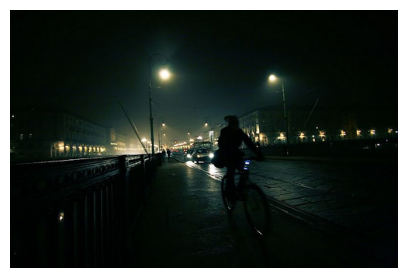

-- 찾은 이미지의 원래 캡션 --
['A girl is riding her bike at night .'
 'A person on a bicycle rides down the city sidewalk at night .'
 'A person walks in the dark near streetlights .'
 'A street light lit bridge with a cyclist and some cars .'
 'The person is bicycling on the street at nighttime .']


In [582]:
# 텍스트로 이미지 검색 실행 (텍스트 -> 이미지)
text = "An orange streetlight is shining on the road in the dark night."  # 이미지를 불러올 설명 텍스트 작성
sample_size = 100  # 실습 데이터셋이 커서 에러가 나므로 폴더에서 해당 수 만큼 랜덤으로 뽑아서 그 중에서 찾기

# 위에서 만든 함수로 입력한 텍스트와 매칭되는 이미지 경로 생성
best_match_path = search_image_by_text(text, sample_size)

# 매칭된 이미지의 원래 캡션 가져오기
file_name = os.path.basename(best_match_path)  # 매치된 이미지 경로로 파일명 구하기
match_orign_captions = captions_df.loc[captions_df['image'] == file_name, 'caption'].values

print(f"입력한 텍스트: {text}")
print("\n" + "-- 데이터셋에서 찾은 이미지 --")
print(f"{sample_size}개 샘플 중 적절한 이미지: {best_match_path}")

# matplotlib로 이미지 함께 출력
image = Image.open(best_match_path)
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

print("-- 찾은 이미지의 원래 캡션 --")
print(match_orign_captions)